# Homework 2.0: 單光子電腦斷層掃描的多類別分類
TODO
1. 實作SwinTransformer
2. 將設定的參數放進SwinTransformer

kaggle rule:
1. 不得使用兩隻以上的帳號繳交 submission檔案 (可參加但不可丟答案)
2. team的名稱記得一定要改成學號

## Import Packages

In [1]:
# torchsummary可以讓模型視覺化，以及匯出模型每層的詳細數量和每層的比例。
!pip install torchsummary

In [2]:
import pydicom
import pandas as pd
import numpy as np
import os
import random

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, Subset, DataLoader
from torchvision.transforms import v2
import torchvision.models as models # VGG16, ResNet50
from torchsummary import summary # summary for models

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score


import warnings
warnings.filterwarnings("ignore", category = FutureWarning)

US1_J2KR.dcm:   0%|          | 38.0/154k [00:00<01:35, 1.61kB/s]
MR-SIEMENS-DICOM-WithOverlays.dcm:   0%|          | 125/511k [00:00<02:56, 2.89kB/s]
OBXXXX1A.dcm:   0%|          | 119/486k [00:00<02:59, 2.70kB/s]
US1_UNCR.dcm:   0%|          | 226/923k [00:00<03:34, 4.30kB/s]
color3d_jpeg_baseline.dcm:   0%|          | 1.50k/6.14M [00:00<07:29, 13.7kB/s]


## Configuration

In [3]:
class config:
    
    root = "/kaggle/input/e3-hw2"
    batch_size = 16
    lr = 1e-4
    epochs = 100
    weight_decay = 1e-3
    seed = 42
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_classes = 3
    
print('device:', config.device)

device: cpu


## Redefined VIT

In [4]:
class Normalization(object):
    
    def __call__(self, image): # 定義有image之後要進行的資料處理
        changed_image = (image - image.min())/(image.max() - image.min())
        return changed_image

def build_transform_ViT(is_train):
    """
    Create a data transformation pipeline for image preprocessing in deep learning tasks.
    """
    t = []
    if is_train:
        # ViT 原本的 input 要求224x224，但我們的影像只有128x128，
        # 為了配合這次50x50，我就把 224/4=56，當作 model 的 input
        # 所以跟原本的 build_transform 有所不同，這裡就改成 build_transform_ViT。
        t.append(v2.CenterCrop(size = (56, 56)))
        t.append(Normalization())
        return v2.Compose(t)
    
    t.append(v2.CenterCrop(size = (56, 56)))
    t.append(Normalization())
    return v2.Compose(t)

接下來要講ViT的部分，先備知識為Attention、Transformer，所以以下提供幾個資源讓大家複習。

1. [【機器學習2021】自注意力機制 (Self-attention) (上)](https://www.youtube.com/watch?v=hYdO9CscNes&list=PLJV_el3uVTsMhtt7_Y6sgTHGHp1Vb2P2J&index=10)

2. [【機器學習2021】自注意力機制 (Self-attention) (下)](https://www.youtube.com/watch?v=gmsMY5kc-zw&list=PLJV_el3uVTsMhtt7_Y6sgTHGHp1Vb2P2J&index=11)

3. [【機器學習2021】Transformer (上)](https://www.youtube.com/watch?v=n9TlOhRjYoc&list=PLJV_el3uVTsMhtt7_Y6sgTHGHp1Vb2P2J&index=12)

4. [【機器學習2021】Transformer (下)](https://www.youtube.com/watch?v=N6aRv06iv2g&list=PLJV_el3uVTsMhtt7_Y6sgTHGHp1Vb2P2J&index=13)

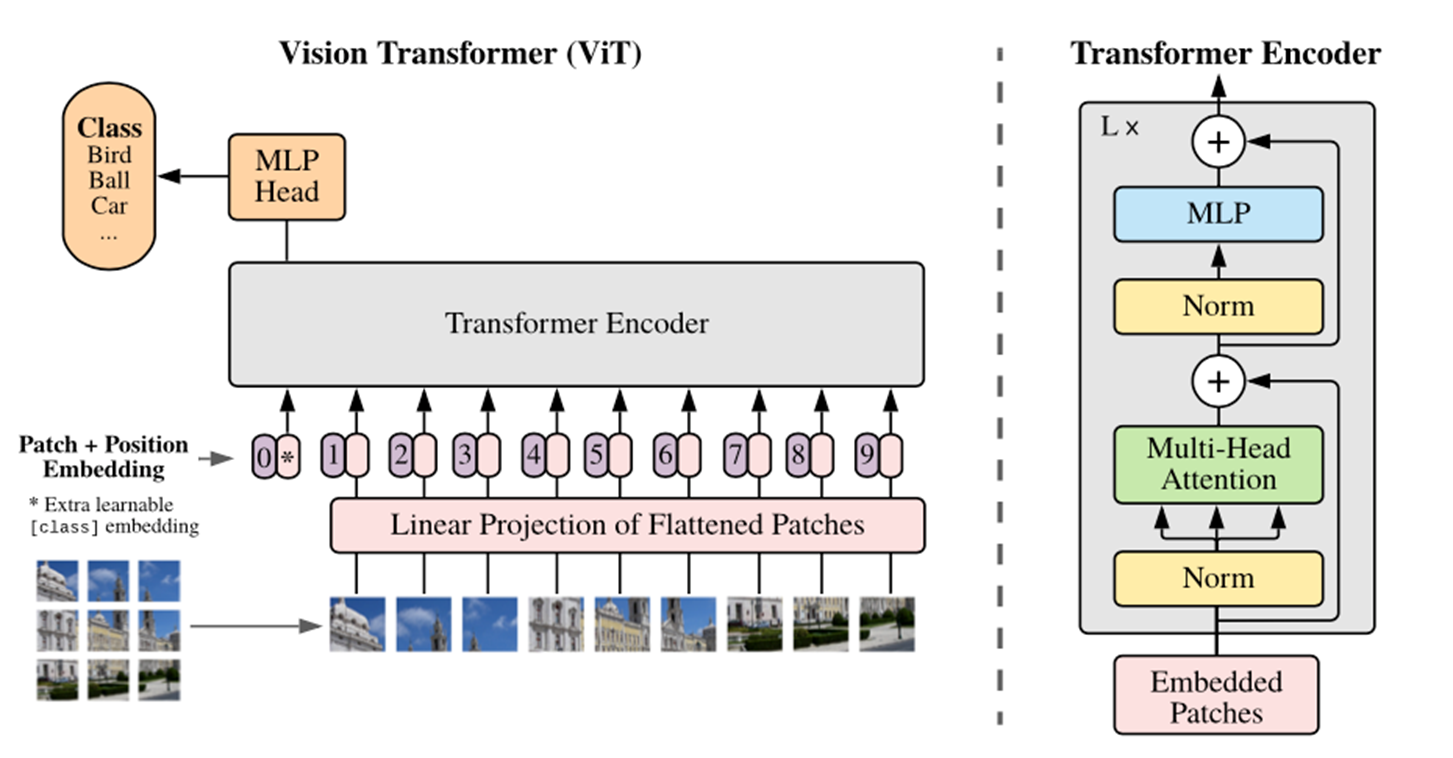

我們的一張醫學影像其長寬為(56,56)，並且通道數為3，為了將其切割成一個個patch，故此會有N個(P,P,C)，

在這裡，我設定一個patch的大小為 8x8，所以會有49個(8,8,3)，

接著flatten之後mapping成transformer可以接受的固定大小，

mapping的結果稱為patch embeddings。在patch前加入一個class，代表圖片的類別。

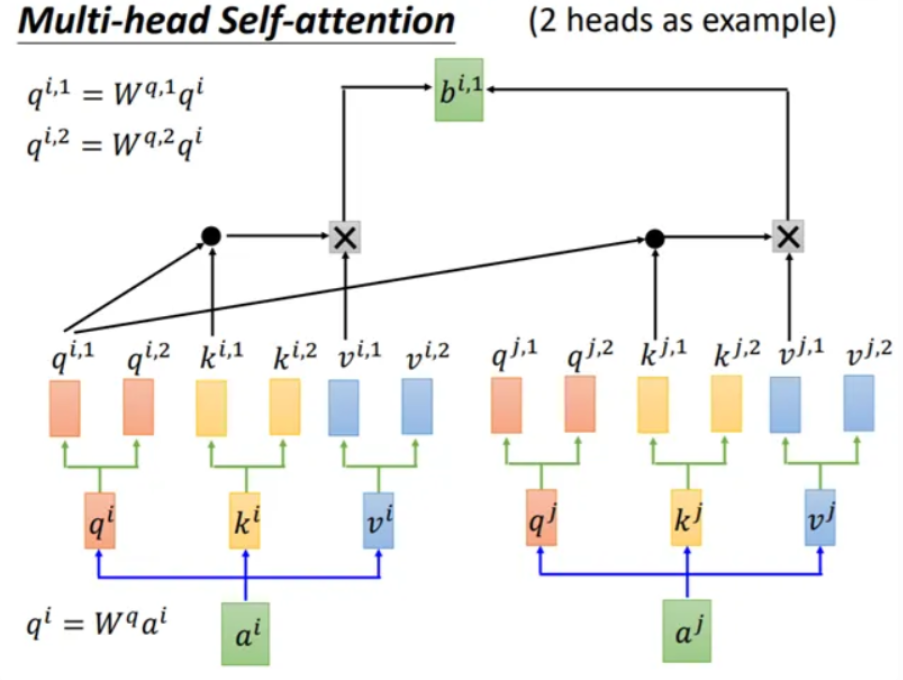

進到Transformer Encoder之後，他會先複製一份，到後面去做殘差連接，降低失真的傷害。

第一步先做 Norm ，之後做 Multi-head Attention ，計算不同 patch 之間的關聯性，也能讓 patch 共享其他 patch 的訊息。

接著做殘差連接與 Norm ，而 MLP 簡單來說就是將 Multi-head Attention 所獲得的特徵進行昇華，提升 model 對影像的理解與分析能力。

更具體一點，MLP就是做非線性轉換。

In [5]:
from timm.models.vision_transformer import VisionTransformer, PatchEmbed

class VisionTransformerCustom(nn.Module):
    def __init__(self, num_classes):
        super(VisionTransformerCustom, self).__init__()
        
        self.model = VisionTransformer(
            img_size=56,                # 影像大小
            patch_size=8,               # 一個 patch 大小
            in_chans=3,                 # input channels 大小
            embed_dim=96,               #  patch 經過展平再 linear 的維度
            embed_layer=PatchEmbed,     # 使用 PatchEmbed 完成上述的動作
            norm_layer=nn.LayerNorm,    # 使用 LayerNorm 來 norm
            depth=12,                   # 使用 12個 Blocks(Encoders)
            num_classes=num_classes     # 輸出的維度
        )
        
        self.model.head = nn.Identity() # 將最後的分類弄成 Identity()

        self.classifier = nn.Sequential(
            nn.Linear(96 + 2, num_classes)  # 把 age, gender 放進其中
        )
        

    def forward(self, x, age, gender):
        x = self.model(x)
        x = torch.cat([x, age.view(-1, 1), gender.view(-1, 1)], dim = 1)
        x = self.classifier(x)
        return x

In [6]:
# 建立 VIT
model = VisionTransformer(
            img_size=56,                # 影像大小
            patch_size=8,               # 一個 patch 大小
            in_chans=3,                 # input channels 大小
            embed_dim=96,               #  patch 經過展平再 linear 的維度
            embed_layer=PatchEmbed,     # 使用 PatchEmbed 完成上述的動作
            norm_layer=nn.LayerNorm,    # 使用 LayerNorm 來 norm
            depth=12,                   # 使用 12個 Blocks(Encoders)
            num_classes=config.num_classes     # 輸出的維度
        )
model.to(config.device)
model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(8, 8), stride=(8, 8))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=96, out_features=288, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=96, out_features=96, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=96, out_features=384, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (fc

In [7]:
summary(model, (3, 56, 56))
del model

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 96, 7, 7]          18,528
          Identity-2               [-1, 49, 96]               0
        PatchEmbed-3               [-1, 49, 96]               0
           Dropout-4               [-1, 50, 96]               0
          Identity-5               [-1, 50, 96]               0
          Identity-6               [-1, 50, 96]               0
         LayerNorm-7               [-1, 50, 96]             192
            Linear-8              [-1, 50, 288]          27,936
          Identity-9            [-1, 12, 50, 8]               0
         Identity-10            [-1, 12, 50, 8]               0
           Linear-11               [-1, 50, 96]           9,312
          Dropout-12               [-1, 50, 96]               0
        Attention-13               [-1, 50, 96]               0
         Identity-14               [-1,

這個是我用正常的模型下去算的，實際上的模型會跟他差一點點，如果要計算這個model的話，以這個為準。

那為什麼不用自己設計的模型去算，因為會出問題。

In [8]:
model = VisionTransformerCustom(config.num_classes)
model.to(config.device)
summary(model, [(3, 56, 56), (1,), (1,)])
del model

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 96, 7, 7]          18,528
          Identity-2               [-1, 49, 96]               0
        PatchEmbed-3               [-1, 49, 96]               0
           Dropout-4               [-1, 50, 96]               0
          Identity-5               [-1, 50, 96]               0
          Identity-6               [-1, 50, 96]               0
         LayerNorm-7               [-1, 50, 96]             192
            Linear-8              [-1, 50, 288]          27,936
          Identity-9            [-1, 12, 50, 8]               0
         Identity-10            [-1, 12, 50, 8]               0
           Linear-11               [-1, 50, 96]           9,312
          Dropout-12               [-1, 50, 96]               0
        Attention-13               [-1, 50, 96]               0
         Identity-14               [-1,

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

意味著 [(3, 56, 56), (1,), (1,)]不是一個有規則的數組，他沒辦法計算model的參數量。

In [9]:
#TODO_1: 設計自己的 SwinTransformer
#參考網站: https://github.com/huggingface/pytorch-image-models/blob/main/timm/models/swin_transformer.py
from timm.models.swin_transformer import SwinTransformer, PatchEmbed

class SwinTransformerCustom(nn.Module):
    def __init__(self, num_classes):
        super(SwinTransformerCustom, self).__init__()

        self.model = SwinTransformer(
            img_size=
            patch_size=
            in_chans=
            embed_dim=
            depths=
            num_heads=
            window_size=
            mlp_ratio=        
            norm_layer=
            num_classes=
        )

        self.model.head.fc = nn.Identity()
        
        self.classifier = nn.Sequential(
            nn.Linear(768 + 2, num_classes)  # 把 age, gender 放進其中
        )
        

    def forward(self, x, age, gender):
        x = self.model(x)
        x = torch.cat([x, age.view(-1, 1), gender.view(-1, 1)], dim=1)
        x = self.classifier(x)
        return x

In [11]:
#TODO_2: 將設定的參數放進SwinTransformer
model = SwinTransformer(

        )
model.to(config.device)
model

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(2, 2), stride=(2, 2))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU(approximate='none')
            (drop1): 

In [12]:
summary(model, (3, 56, 56))
del model

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 28, 28]           1,248
         LayerNorm-2           [-1, 28, 28, 96]             192
        PatchEmbed-3           [-1, 28, 28, 96]               0
          Identity-4           [-1, 28, 28, 96]               0
         LayerNorm-5           [-1, 28, 28, 96]             192
            Linear-6              [-1, 49, 288]          27,936
           Softmax-7            [-1, 3, 49, 49]               0
           Dropout-8            [-1, 3, 49, 49]               0
            Linear-9               [-1, 49, 96]           9,312
          Dropout-10               [-1, 49, 96]               0
  WindowAttention-11               [-1, 49, 96]               0
         Identity-12           [-1, 28, 28, 96]               0
        LayerNorm-13              [-1, 784, 96]             192
           Linear-14             [-1, 7

In [13]:
model = SwinTransformerCustom(config.num_classes)
model.to(config.device)
summary(model, [(3, 56, 56), (1,), (1,)])
del model

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 28, 28]           1,248
         LayerNorm-2           [-1, 28, 28, 96]             192
        PatchEmbed-3           [-1, 28, 28, 96]               0
          Identity-4           [-1, 28, 28, 96]               0
         LayerNorm-5           [-1, 28, 28, 96]             192
            Linear-6              [-1, 49, 288]          27,936
           Softmax-7            [-1, 3, 49, 49]               0
           Dropout-8            [-1, 3, 49, 49]               0
            Linear-9               [-1, 49, 96]           9,312
          Dropout-10               [-1, 49, 96]               0
  WindowAttention-11               [-1, 49, 96]               0
         Identity-12           [-1, 28, 28, 96]               0
        LayerNorm-13              [-1, 784, 96]             192
           Linear-14             [-1, 7

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

# Note

In [ ]:
def main():
    # 注意這裡的 build_transform 要更正為 build_transform_ViT 
    train_dataset = ParkinsonsDataset(train_dataset, transforms = build_transform_ViT(True), mode = "train")
    val_dataset = ParkinsonsDataset(val_dataset, transforms = build_transform_ViT(False), mode = "valid")